# Word Clouds
Here we will visualize how the flavor text of cards differ by color and card type using word clouds.

We use the following package to create word clouds https://github.com/amueller/word_cloud

In [1]:
import datetime, os, requests, time
import numpy as np
import pandas as pd
import CF_standard_functions as cf
import pickle as pkl
from pathlib import Path

First we load the data. Here this is done with a wrapper function. To see how it works, check out **Color_from_Flavor.ipynb** or the source code in **CF_standard_functions.py** \
_(If a local file exists, we load that instead)_

In [2]:
# Set these directories to determine where to save/load the data from:
savepath = "card_data"
filename = 'CardData.pkl'
# Directory for getting data from Scryfall:
sf_bulk_url = "https://api.scryfall.com/bulk-data"

if (os.path.isfile(savepath+filename)) and (cf.file_age_in_hours(savepath+filename) < 24):
    print('Loading card data from file...')
    with open(Path(savepath,filename),'rb') as datafile:
        df = pkl.load(datafile)
    print('Done!')
else:
    df = cf.data_from_scryfall()
    
print(f"{df.shape[0]} cards with unique flavor text in data set")

Loading card data from file...
Done!
22759 cards with unique flavor text in data set


In [3]:
df_mono = cf.parse_monocolor_cards(df)
df_mono.reset_index(drop=True,inplace=True)
df_mono.head()
print(f"{df_mono.shape[0]} monocolor cards with distinct flavor text")

17354 monocolor cards with distinct flavor text


### Word cloud of all flavor text
Following this tutorial: https://www.datacamp.com/tutorial/wordcloud-python

Note that when running this on Windows (as I am) you will need to specify a path to a font when generating the WordCloud object. Do so with the _font_path_ parameter. I am using basic Calibri here.

In [10]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib
from matplotlib import pyplot as plt
from PIL import Image

matplotlib.rcParams['figure.figsize'] = [5, 3]

First, clean up the flavor text by removing all special characters. This uses a custom function, which is a wrapper for some regular expression parsing and replacement.

_(This isn't a perfect way to preprocess, as some flavor text has weird formatting.)_

In [5]:
df_mono['flavor_text_clean']=df_mono.flavor_text.apply(lambda x: cf.remove_special_characters(x))

In [7]:
df_mono.head()

,name,colors,flavor_text,flavor_text_clean
0,Wild Aesthir,W,"""what barbarian secrets do they spy from their...",what barbarian secrets do they spy from their ...
1,Aysen Bureaucrats,W,"""i would say that our bureaucrats are no bette...",i would say that our bureaucrats are no better...
2,Oswald Fiddlebender,W,"""can't see this airship crashing in the near f...",cant see this airship crashing in the near fut...
3,Ashes of the Abhorrent,W,"""let no trace of the vampires' foulness remain.""",let no trace of the vampires foulness remain
4,Ray of Revelation,W,"""may angels carry him into the blessed sleep w...",may angels carry him into the blessed sleep wi...


In [20]:
# ALL text of all cards!
stopwords = set(STOPWORDS) # Words to ignore
font_path = os.environ.get("FONT_PATH", "/Library/Fonts/Arial unicode.ttf")
wordcloud = WordCloud(font_path=font_path,
                      stopwords=stopwords,
                      width = 1600, height = 800,
                      colormap='Spectral',background_color='black')
# Wordcloud expects a single string rather than a list of strings
text_all = df_mono.flavor_text_clean.str.cat(sep=' ')


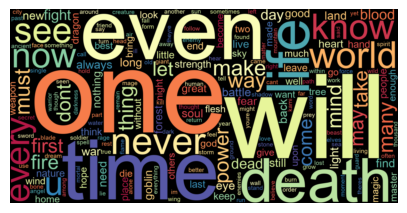

In [21]:

wordcloud.generate(text_all)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

You can see that the words "one", "will", and "even" are very common. We will add these to our stopwords to filter them out from future plots.

In [22]:
stopwords = stopwords.union({'will','even','one'})
wordcloud.stopwords = stopwords

## Word Clouds by Color 

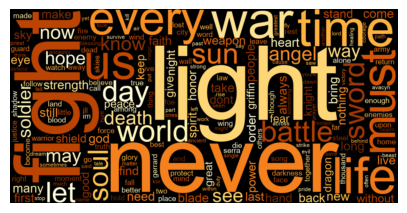

In [23]:
# White
white_text = df_mono.flavor_text_clean[df_mono.colors == 'W'].str.cat(sep=' ')
wordcloud.generate(white_text)
wordcloud.recolor(colormap = 'YlOrBr')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

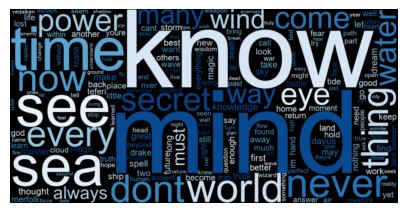

In [24]:
# Blue
blue_text = df_mono.flavor_text_clean[df_mono.colors == 'U'].str.cat(sep=' ')
wordcloud.generate(blue_text)
wordcloud.recolor(colormap='Blues')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

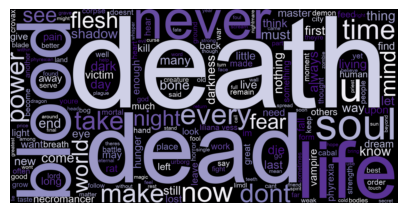

In [25]:
# Separated by colors: 
# Black
black_text = df_mono.flavor_text_clean[df_mono.colors == 'B'].str.cat(sep=' ')
wordcloud.background_color = 'black'
wordcloud.generate(black_text).recolor(colormap = 'Purples')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

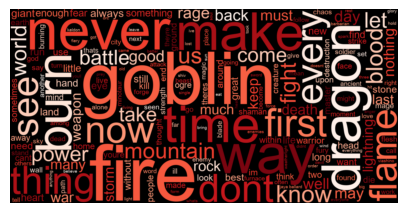

In [26]:
# Red
red_text = df_mono.flavor_text_clean[df_mono.colors == 'R'].str.cat(sep=' ')
wordcloud.generate(red_text)
wordcloud.recolor(colormap='Reds')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

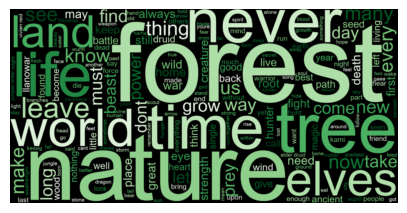

In [27]:
# Green
green_text = df_mono.flavor_text_clean[df_mono.colors == 'G'].str.cat(sep=' ')
wordcloud.generate(green_text)
wordcloud.recolor(colormap = 'Greens')
wordcloud.background_color = 'black'
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

We can also try colorless cards! This will contain both lands and (most) artifacts.

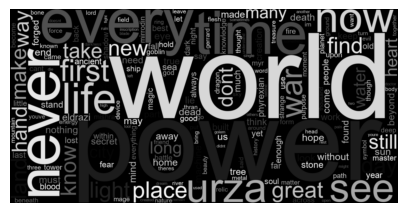

In [28]:
df_colorless = df[df.colors.str.len() == 0].copy()
df_colorless['flavor_text_clean']=df_colorless.flavor_text.apply(lambda x: cf.remove_special_characters(x))
colorless_text = df_colorless['flavor_text_clean'].str.cat(sep=' ')
wordcloud.generate(colorless_text)
wordcloud.recolor(colormap = 'Greys')
wordcloud.background_color = 'black'
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Now let's separate lands and nonland colorless cards

(-0.5, 1599.5, 799.5, -0.5)

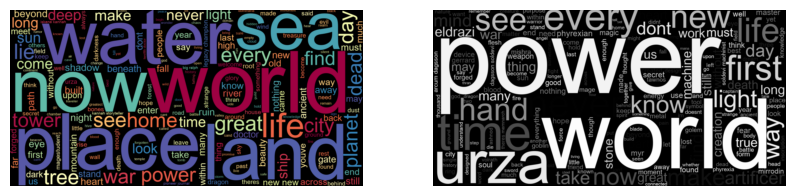

In [29]:
df_land = df_colorless[df_colorless['type_line'].apply(lambda x : 'Land' in x)]
df_nonland = df_colorless[df_colorless['type_line'].apply(lambda x : 'Land' not in x)]

land_text = df_land['flavor_text_clean'].str.cat(sep=' ')
nonland_text = df_nonland['flavor_text_clean'].str.cat(sep=' ')

fig,ax = plt.subplots(1,2,sharey=True,figsize=[10,7])
wordcloud.generate(land_text)
wordcloud.background_color = 'black'
ax[0].imshow(wordcloud, interpolation='bilinear')
ax[0].axis('off')

wordcloud.generate(nonland_text)
wordcloud.recolor(colormap = 'Greys')
ax[1].imshow(wordcloud,interpolation='bilinear')
ax[1].axis('off')